## Assignment 9 - Monica Zhang
https://spark.apache.org/docs/latest/ml-features#lsh-operations  
https://databricks.com/blog/2017/05/09/detecting-abuse-scale-locality-sensitive-hashing-uber-engineering.html

In [1]:
import sys
print(sys.version)
print(spark.version)

3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]
3.1.3


In [2]:
import os
import subprocess
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [3]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [6]:
%pip install nltk -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.3/772.3 kB 51.1 MB/s eta 0:00:00
  Attempting uninstall: regex
    Found existing installation: regex 2021.4.4
    Uninstalling regex-2021.4.4:
      Successfully uninstalled regex-2021.4.4
  Attempting uninstall: nltk
    Found existing installation: nltk 3.6.4
    Uninstalling nltk-3.6.4:
      Successfully uninstalled nltk-3.6.4
Note: you may need to restart the kernel to use updated packages.


In [5]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
spark = SparkSession.builder \
.appName('app_name') \
.master('local[*]') \
.config('spark.sql.execution.arrow.pyspark.enabled', True) \
.config('spark.sql.session.timeZone', 'UTC') \
.config('spark.driver.memory','32G') \
.config('spark.ui.showConsoleProgress', True) \
.config('spark.sql.repl.eagerEval.enabled', True) \
.getOrCreate()

#### Add "eagerEval.enabled" to beautify the way Spark DF is displayed

In [6]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [7]:
df = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/monicazhang/final_project_eda_154M_2.parquet')

23/03/09 20:50:16 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [8]:
df.limit(5)

coordinates,created_at,favorite_count,favorited,filter_level,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,is_quote_status,lang,place,quote_count,quoted_status,quoted_status_id,quoted_text,reply_count,retweet_count,retweeted,retweeted_from,retweeted_status,source,text,timestamp_ms,truncated,tweet_text,user,entities,extended_entities,extended_tweet,geo,place.country,place.full_name,place.name,place.place_type,user.id,user.name,user.screen_name,user.location,user.created_at,user.description,user.followers_count,user.friends_count,user.listed_count,user.favourites_count,user.statuses_count,user.url,user.verified,retweets_count,user_type
null,Fri Apr 22 12:07:...,0,false,low,1517475259812827137,null,null,null,false,en,null,0,null,null,null,0,0,RT,kfaisalhospital,"{null, Fri Apr 22...","<a href=""http://t...",RT @kfaisalhospit...,1650629269923,false,We're celebrating...,"{false, Thu Nov 2...","{[], null, [], []...",null,null,null,null,null,null,null,1199961840916353024,Be Kind 😎✊,Ishimwe71,null,Thu Nov 28 08:03:...,Pharmacist 👩‍🎓?...,29627,1373,11,75067,34233,null,false,76,other
null,Fri Apr 22 12:08:...,0,false,low,1517475355115724801,null,null,null,false,en,null,0,null,null,null,0,0,RT,bgmasters,"{null, Fri Apr 22...","<a href=""http://t...",RT @bgmasters: Ta...,1650629292645,false,Taxpayers shouldn...,"{false, Sat Sep 1...","{[], null, [], []...",null,null,null,null,null,null,null,774699551764525056,MAGA RN 🍊🙏🇺🇸🚚,Willsdarlin,"Washington, USA",Sat Sep 10 20:02:...,Registered Nurse ...,7613,6801,66,338866,529143,null,false,110,other
null,Fri Apr 22 12:08:...,0,false,low,1517475369930170368,null,null,null,false,en,null,0,null,null,null,0,0,RT,EduCannotWait,"{null, Fri Apr 22...","<a href=""http://t...",RT @EduCannotWait...,1650629296177,false,“#ECW joins the i...,"{false, Sun Dec 2...","{[{[20, 24], ECW}...",null,null,null,null,null,null,null,98174194,Manan Kotak,mananmkotak,null,Sun Dec 20 18:03:...,Working for Educa...,582,799,3,6827,3189,null,false,5,other
null,Fri Apr 22 12:09:...,0,false,low,1517475773543858177,null,null,null,false,en,null,0,null,null,null,0,0,RT,EduCannotWait,"{null, Fri Apr 22...","<a href=""http://t...",RT @EduCannotWait...,1650629392406,false,“#ECW joins the i...,"{false, Fri Sep 0...","{[{[20, 24], ECW}...",null,null,null,null,null,null,null,906251229302546432,Nasser Faqih,NasserFaqihUN,Al Quds,Fri Sep 08 20:21:...,“You brought me c...,416,578,1,4895,3979,null,false,9,other
null,Fri Apr 22 12:10:...,0,false,low,1517475839541223426,JonahTillman6,1517267513427509248,1277019696706060290,false,en,null,0,null,null,null,0,0,,null,null,"<a href=""http://t...",@JonahTillman6 An...,1650629408141,false,@JonahTillman6 An...,"{false, Sun Mar 3...","{[], null, [], []...",null,null,null,null,null,null,null,1317396996,Scott G,scottg4914,"Alabama, USA",Sun Mar 31 00:16:...,Retired Col USAF ...,5691,6142,4,25612,23465,null,false,null,other


In [8]:
df = df.withColumn('hashtags', expr("entities.hashtags.text"))

In [16]:
df.count()

1541655

In [18]:
df_goverment = df.filter(col('user_type')=='government')

In [19]:
df_goverment.count()

3079

In [96]:
df_text_raw = df_goverment.select(col('tweet_text').alias('text'))
#filter((col('retweeted') != 'RT') & (col('is_quote_status') == 'false'))

In [97]:
df_text_raw.show(5, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                                                                                                                                                                    |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|@pstumler Poor people will not be able to go to major colleges without federally subsidized loans.

It is why the system was created in the first plac

In [98]:
text = df_text_raw.rdd.map(lambda x : x['text']).filter(lambda x: x is not None) 

StopWords = stopwords.words("english")

tokens = text\
     .map( lambda document: document.strip().lower())\
     .map( lambda document: re.split(" ", document))\
     .map( lambda word: [x for x in word if x.isalnum()])\
     .map( lambda word: [x for x in word if x not in StopWords])\
     .map( lambda word: [x for x in word if len(x) > 1] )\
     .zipWithIndex()

In [99]:
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])
df_text.limit(5)

text,id
{@pstumler Poor p...,0
{Smart higher ed ...,1
{If tuition-free ...,2
"{""It stinks that ...",3
{For all your col...,4


In [100]:
df_text.count()

1980

In [101]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[poor, people, able, go, major, colleges, without, federally, subsidized, system, created, first, higher, education, america]",0
1,"[smart, higher, ed, forgive, loans, students, harmed, predatory, colleges, tighten, institutional, eligibility, student, loan, make, institutions, share, cost, future, loan, cap, grad, plus, use, savings, increase, pell, grants]",1
2,"[university, education, also, fact, pay, fee, call, 911, police, come, house, robbed, bombing, innocent, civilians, iraq, grow]",2
3,"[stinks, make, even, sacrifices, school, student, loan, debt, would, canceling, debt, solve]",3
4,[discourse],4


In [102]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [103]:
df_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[poor, people, able, go, major, colleges, without, federally, subsidized, system, created, first, higher, education, america]",0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[smart, higher, ed, forgive, loans, students, harmed, predatory, colleges, tighten, institutional, eligibility, student, loan, make, institutions, share, cost, future, loan, cap, grad, plus, use, savings, increase, pell, grants]",1,"(1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[university, education, also, fact, pay, fee, call, 911, police, come, house, robbed, bombing, innocent, civilians, iraq, grow]",2,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[stinks, make, even, sacrifices, school, student, loan, debt, would, canceling, debt, solve]",3,"(1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,[discourse],4,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


In [104]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize)#.cache()

In [105]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left')#.cache()
df_hashed_text.limit(5)

id,text,list_of_words,features,hashes
418,{@riotta I have s...,"[warm, memory, sh...","(6114,[6,56,66,69...","[[3547010.0], [1...."
367,{3 Good Things: S...,"[good, sniff, win...","(6114,[1,15,133,9...","[[6.3093256E7], [..."
348,{This is a real c...,"[real, college, s...","(6114,[1,2,5,11,3...","[[1.75609176E8], ..."
415,{Today our innoce...,"[today, innocent,...","(6114,[2,53,67,75...","[[2.7764414E7], [..."
385,{Calculating Stud...,"[calculating, stu...","(6114,[0,2,7,9,21...","[[4.7945584E7], [..."


In [106]:
jaccard_distance = 0.5

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

In [107]:
df_dups_50 = df_dups_text
df_dups_text.cache()
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.0,1773,1824,"(This morning: 100s of students at Isfahan University protest in support of Sharif University students, who were attacked by security forces yesterday. The crackdown on Sharif students will inflame student protests throughout Iran. #MahsaAmini #مهسا_امینی https://t.co/rELTRWpVV3,)","(This morning: 100s of students at Isfahan University protest in support of Sharif University students, who were attacked by security forces yesterday. The crackdown on Sharif students will inflame student protests throughout Iran. #MahsaAmini #مهسا_امینی https://t.co/rELTRWpVV3,)"
1,0.0,694,846,"(Calling early career journalists: @Reuters + Durham University are offering a 6- to 9-month fellowship which includes an investigative project overseen by the best editors in the biz. A sensational opportunity for an ambitious reporter…\n\nhttps://t.co/pPiMwXfc2Q #journalismjobs https://t.co/AvphJSV9KA,)","(Calling early career journalists: @Reuters + Durham University are offering a 6- to 9-month fellowship which includes an investigative project overseen by the best editors in the biz. A sensational opportunity for an ambitious reporter…\n\nhttps://t.co/pPiMwXfc2Q #journalismjobs https://t.co/AvphJSV9KA,)"
2,0.0,1458,1625,"(Debt-free college: California’s on the verge of spending over a half-billion dollars to help 360,000 students https://t.co/iwrh7TnchM,)","(Debt-free college: California’s on the verge of spending over a half-billion dollars to help 360,000 students https://t.co/uD5pSn3FQM,)"
3,0.0,51,276,"(I stand in strong solidarity with the 48,000 academic workers at the University of California who are on strike for higher wages, better child care benefits, and expanded paid leave.,)","(I stand in strong solidarity with the 48,000 academic workers at the University of California who are on strike for higher wages, better child care benefits, and expanded paid leave.,)"
4,0.0,1011,1372,"(The Biden administration released a proposal that will make it easier for students who claim they were defrauded by for-profit colleges to get their federal student loans forgiven, moving to reverse Trump administration limits https://t.co/Ym8PNZZNzf,)","(The Biden administration released a proposal that will make it easier for students who claim they were defrauded by for-profit colleges to get their federal student loans forgiven, moving to reverse Trump administration limits https://t.co/b1SybGHlFC,)"


In [108]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  1980
Duplicate titles based on { 0.5 } jaccard distance:  275
Unique titles based on { 0.5 } jaccard distance:  0.5 :  1705


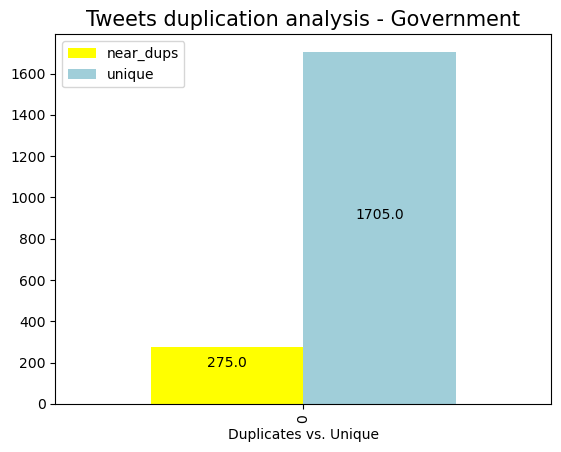

In [109]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['yellow', '#A0CED9'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweets duplication analysis - Government', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [110]:
df_dups_text.unpersist()

distCol,id_A,id_B,text_A,text_B
0.0,447,1200,{As University of...,{As University of...
0.0,1105,1106,{A new survey rev...,{A new survey rev...
0.0,698,1041,{@tom_steely From...,{@Amor_Fati2015 F...
0.0,122,123,{There is a long ...,{There is a long ...
0.09999999999999998,951,1242,{Breaking News: T...,{The U.S. will ca...
0.16666666666666663,1016,1219,{D.C. middle scho...,{D.C. middle scho...
0.0,1560,1817,{A scholarship (i...,{A scholarship (i...
0.0,1660,1714,{JUST IN: The Sup...,{JUST IN: The Sup...
0.0,1458,1625,{Debt-free colleg...,{Debt-free colleg...
0.0,545,1636,{Gen Z is definit...,{Gen Z is definit...


In [45]:
df_news = df.filter(col('user_type')=='news')

In [46]:
df_news.count()

1980

In [63]:
df_nonprofit = df.filter(col('user_type')=='non-profit')

In [64]:
df_nonprofit.count()

583

In [111]:
df_influencer = df.filter(col('user_type')=='influencer')

In [112]:
df_influencer.count()

7077

In [9]:
df_other = df.filter(col('user_type')=='other')

In [10]:
df_other.count()

1526238

In [80]:
df_school = df.filter(col('user_type')=='school or university')

In [81]:
df_school.count()

2698

In [11]:
df_text_raw = df_other.filter((col('retweeted') != 'RT') & (col('is_quote_status') == 'false')).select(col('tweet_text').alias('text'))

In [12]:
df_text_raw.count()

414362

In [13]:
df_text_raw = df_text_raw.sample(fraction=0.025)

In [14]:
df_text_raw.count()

10400

In [15]:
text = df_text_raw.rdd.map(lambda x : x['text']).filter(lambda x: x is not None) 

StopWords = stopwords.words("english")

tokens = text\
     .map( lambda document: document.strip().lower())\
     .map( lambda document: re.split(" ", document))\
     .map( lambda word: [x for x in word if x.isalnum()])\
     .map( lambda word: [x for x in word if x not in StopWords])\
     .map( lambda word: [x for x in word if len(x) > 1] )\
     .zipWithIndex()

In [16]:
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])
df_text.limit(5)

text,id
{We've created de...,1038
{Reminder that pe...,1039
{@ATweetingTwit9 ...,1040
{@BowTiedEffer @J...,1041
{@itsJeffTiedrich...,1042


In [17]:
df_text.count()

10400

In [18]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[disabled, american, paid, entire, college, tuition, get, cent, government, fucking, brats, need, grow]",0
1,"[texas, semester, think, meal, back, 90s, payable, student, act, like, people, going, college, years, ago, paying, comparable]",1
2,"[school, paying, tuition, porn, valley]",2
3,"[luckily, private, school, wife, plan, retire, last, year, middle, get, job, private, school, get, huge, break]",3
4,"[lunacy, people, college, debt, want, pay, need, yr, college, degree, give, back, society, make, comfortable, asking, people, make, less, money, pay]",4


In [19]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [20]:
df_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[disabled, american, paid, entire, college, tuition, get, cent, government, fucking, brats, need, grow]",0,"(1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[texas, semester, think, meal, back, 90s, payable, student, act, like, people, going, college, years, ago, paying, comparable]",1,"(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[school, paying, tuition, porn, valley]",2,"(0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[luckily, private, school, wife, plan, retire, last, year, middle, get, job, private, school, get, huge, break]",3,"(0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[lunacy, people, college, debt, want, pay, need, yr, college, degree, give, back, society, make, comfortable, asking, people, make, less, money, pay]",4,"(2.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


In [21]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize)#.cache()

In [22]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left')#.cache()
df_hashed_text.limit(5)

id,text,list_of_words,features,hashes
4371,{@Aminesque @yoge...,"[start, peanuts, ...","(14881,[3,7,10,17...","[[1.35246836E8], ..."
4551,{@KassyDillon Let...,"[let, us, ask, co...","(14881,[1,6,7,15,...","[[7.3175978E7], [..."
4191,{@Outkick Get a P...,"[get, phd, biden,...","(14881,[1,6,9,97,...","[[1.46342548E8], ..."
4509,{Art of Problem S...,"[art, problem, so...","(14881,[2,92,139,...","[[5.75251383E8], ..."
4519,{We awarded Angel...,"[awarded, angela,...","(14881,[2,235,328...","[[2.95706795E8], ..."


In [23]:
jaccard_distance = 0.5

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

In [24]:
df_dups_50 = df_dups_text
df_dups_text.cache()
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.000,781,3946,"(@WSJ Education is a human right! The current college education system FORCES debt onto borrowers without bankruptcy rights or consumer protections this is #unconstitutional \n45 million Americans are trapped in indentured servitude because of this!\n#CancelStudentDebt @POTUS https://t.co/h9jKCbDjtS,)","(@Ilhan Education is a human right! The current college education system FORCES debt onto borrowers without bankruptcy rights or consumer protections this is #unconstitutional \n45 million Americans are trapped in indentured servitude because of this!\n#CancelStudentDebt @POTUS https://t.co/hax71krtcM,)"
1,0.000,5682,10104,"(Join @vanessa_vash, @Malala and human rights champions’ urgent call on world leaders to expand children’s right to free education #AllKidsInSchool #TransformingEducation. Add your voice here: https://t.co/YEj5lV4H4c,)","(Join @vanessa_vash, @Malala and human rights champions’ urgent call on world leaders to expand children’s right to free education #AllKidsInSchool #TransformingEducation. Add your voice here: https://t.co/O9YluDTJjx,)"
2,0.125,4374,8795,"(@thehill https://t.co/SPjxnvtrEY please help my son with college tuition anything will be greatly appreciated thank you and please share his GoFundMe it’s so hard asking others for help 😩🙏🏽,)","(@sunnie1ee @tedcruz https://t.co/SPjxnvtrEY please help my son with college tuition anything will be greatly appreciated thank you and please share his GoFundMe it’s so hard asking others for help 😩🙏🏽 please find it in your heart to help please 🙏🏽❤️,)"
3,0.000,4197,8439,"(Free Education University - How to find scholarships and grants specifically tailored to your personality type, hobbies, college major(s), and much more! 🔗 Link in Bio https://t.co/ObNdbMd3jx,)","(Free Education University - How to find scholarships and grants specifically tailored to your personality type, hobbies, college major(s), and much more! 🔗 Link in Bio https://t.co/GqqLpkGxdT,)"
4,0.000,3443,9984,"(Free Education University - How to find scholarships and grants specifically tailored to your personality type, hobbies, college major(s), and much more! 🔗 Link in Bio https://t.co/ha4E7nDgtr,)","(Free Education University - How to find scholarships and grants specifically tailored to your personality type, hobbies, college major(s), and much more! 🔗 Link in Bio https://t.co/XlW1hLQNd9,)"


In [25]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  10400
Duplicate titles based on { 0.5 } jaccard distance:  773
Unique titles based on { 0.5 } jaccard distance:  0.5 :  9627


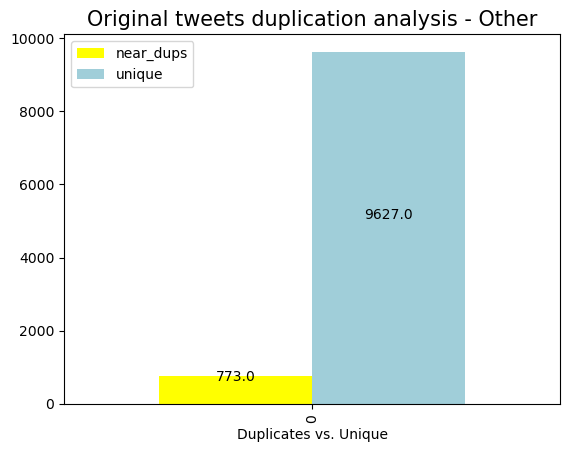

In [26]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['yellow', '#A0CED9'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Original tweets duplication analysis - Other', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [127]:
df_dups_text.unpersist()

distCol,id_A,id_B,text_A,text_B
0.0,1221,1340,{.@SecCardona on ...,{.@SecCardona on ...
0.0,1096,3056,{Supreme Court ru...,{Supreme Court ru...
0.25,2065,2937,{Select the colle...,{Enter the colleg...
0.0,674,3082,{#AD Unicaf is th...,{#AD Unicaf is th...
0.41666666666666663,2182,3048,{The Special Inve...,{SIU recovers R33...
0.0,529,3013,{Attended one of ...,{Attended one of ...
0.0,2286,3058,{WATCH: @TheView ...,{WATCH: @TheView ...
0.0,733,3020,{If you plan to a...,{If you plan to a...
0.46153846153846156,3015,3118,{Supreme Court Ru...,{Supreme Court sa...
0.10526315789473684,2877,3101,{The president of...,{Dartmouth Colleg...


In [10]:
df_text_raw = df.filter((col('retweeted') != 'RT') & (col('is_quote_status') == 'false')).select(col('tweet_text').alias('text'))

In [12]:
df_text_raw.show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                                                                                                                                                                                               |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|@bestgtor88 @TheCalvinCooli1 Voted down a voter ID initiative
Voted f

In [11]:
df_text_raw.count()

423578

In [14]:
df_text_raw = df_text_raw.sample(fraction=0.025)

In [15]:
df_text_raw.count()

10630

In [16]:
text = df_text_raw.rdd.map(lambda x : x['text']).filter(lambda x: x is not None) 

StopWords = stopwords.words("english")

tokens = text\
     .map( lambda document: document.strip().lower())\
     .map( lambda document: re.split(" ", document))\
     .map( lambda word: [x for x in word if x.isalnum()])\
     .map( lambda word: [x for x in word if x not in StopWords])\
     .map( lambda word: [x for x in word if len(x) > 1] )\
     .zipWithIndex()

In [17]:
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])
df_text.limit(10)

text,id
{@joshuarhett @An...,0
{@itsJeffTiedrich...,1
{@fatoomtyzarah F...,2
"{@CNN Libs: ""Pay...",3
{@WinslowAaron @W...,4
{@QasimRashid Sor...,5
{@HeerJeet Obviou...,6
{@TheBROBQ Well s...,7
{Big Increase in ...,8
{@MittRomney Forg...,9


In [18]:
df_text.count()

10630

In [19]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
df_tokens.limit(5)#.toPandas()

list_of_words,id
"[must, pay, less,...",561
"[dalio, adam, gra...",562
"[trades, people, ...",563
"[stupid, believe,...",564
"[thise, whose, ho...",565


In [20]:
df_tokens.printSchema()

root
 |-- list_of_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: long (nullable = true)



In [21]:
df_tokens.count()

10630

In [22]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [23]:
df_vectorize.limit(5)#.toPandas()

list_of_words,id,features
"[must, pay, less,...",561,"(15175,[2,4,12,16..."
"[dalio, adam, gra...",562,"(15175,[2,5,12,16..."
"[trades, people, ...",563,"(15175,[1,2,11,17..."
"[stupid, believe,...",564,"(15175,[1,2,4,8,3..."
"[thise, whose, ho...",565,"(15175,[1,3,6,29,..."


In [24]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize)#.cache()

In [25]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left')#.cache()
df_hashed_text.limit(5)

id,text,list_of_words,features,hashes
1224,{@ameliareivers @...,"[need, congress, ...","(15175,[0,10,23,2...","[[3.1294153E7], [..."
1258,{@caroljsroth It ...,"[credit, card, de...","(15175,[0,4,6,38,...","[[4.7945584E7], [..."
1277,{@TedNugent Plumb...,"[plumbers, go, go...","(15175,[1,2,14,43...","[[2.53318475E8], ..."
1360,{@POTUS So now al...,"[america, paying,...","(15175,[0,1,4,7,1...","[[4.7945584E7], [..."
1127,{@DustinDank_420 ...,"[fix, cost, loans...","(15175,[8,11,14,2...","[[6.9646239E7], [..."


In [26]:
jaccard_distance = 0.3

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

In [29]:
df_dups_30 = df_dups_text
df_dups_text.cache()
df_dups_text.limit(5)#.toPandas()

distCol,id_A,id_B,text_A,text_B
0.0,2640,9068,{Free Education U...,{Free Education U...
0.0,8521,9680,{Free Education U...,{Free Education U...
0.0,5993,9617,{Free Education U...,{Free Education U...
0.0,2245,2640,{Free Education U...,{Free Education U...
0.0,4351,6197,{Free Education U...,{Free Education U...


In [30]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  10630
Duplicate titles based on { 0.3 } jaccard distance:  601
Unique titles based on { 0.3 } jaccard distance:  0.3 :  10029


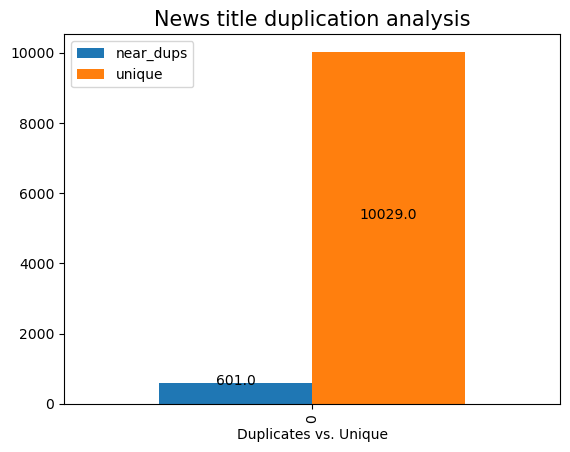

In [32]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News title duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [33]:
df_dups_text.unpersist()

distCol,id_A,id_B,text_A,text_B
0.09999999999999998,4293,4594,{The difference b...,{The difference b...
0.26315789473684215,720,2571,{@CoinMarketCap F...,{@magpieprotocol ...
0.05882352941176472,720,8230,{@CoinMarketCap F...,{@DiorWgmi @RJWGM...
0.0,720,6472,{@CoinMarketCap F...,{@farukkara632 @H...
0.0,1042,1577,{@bridgenetwork0x...,{@SweetApesNFT Fr...
0.26315789473684215,1042,4575,{@bridgenetwork0x...,{@Roykings1 Hello...
0.05882352941176472,872,8209,{@OkayDuckYC @bti...,{@BlizzFinance Fr...
0.0,4382,5550,{@mabling Friends...,{@Dogecoinupdate ...
0.0625,4074,6107,{@MoonStepApp @BN...,{@RichardHeartWin...
0.0,4186,4946,{@WhaleEverything...,{@kawakami_io Fri...


In [34]:
jaccard_distance = 0.5

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            ) 

In [35]:
df_dups_50 = df_dups_text
df_dups_text.cache()
df_dups_text.limit(5)#.toPandas()

distCol,id_A,id_B,text_A,text_B
0.0,4158,9606,{Time Management ...,{Time Management ...
0.0,4646,5533,{@uwizeyeblair Pa...,{@Anita__Akuffo P...
0.33333333333333337,2137,5002,{@Super70sSports ...,{@adinross Pay fo...
0.33333333333333337,5684,9421,{College tuition ...,{@TheBroAMG Colle...
0.0,1810,5876,{@noahjacobmama S...,{@RussellIan5 Col...


In [36]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  10630
Duplicate titles based on { 0.5 } jaccard distance:  771
Unique titles based on { 0.5 } jaccard distance:  0.5 :  9859


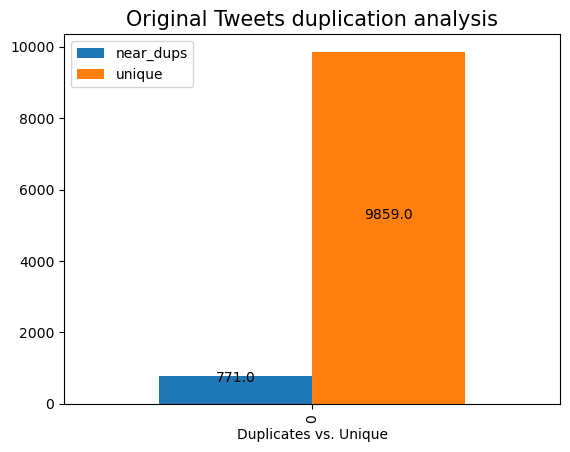

In [38]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Original Tweets duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [39]:
df_dups_text.unpersist()

distCol,id_A,id_B,text_A,text_B
0.0,5032,9643,{Join @vanessa_va...,{Join @vanessa_va...
0.0,6700,9643,{Join @vanessa_va...,{Join @vanessa_va...
0.3076923076923077,8841,10250,{The difference b...,{The difference b...
0.09999999999999998,4293,4594,{The difference b...,{The difference b...
0.0,7986,8226,{@apatwx @marklev...,{@Stlcardcollect4...
0.0,3648,7414,{Join @vanessa_va...,{Join @vanessa_va...
0.30000000000000004,1038,3516,"{Yes, you can sti...","{Yes, you can sti..."
0.25,1012,10250,{The difference b...,{The difference b...
0.18181818181818177,1012,4594,{The difference b...,{The difference b...
0.4285714285714286,7729,8790,{Gonzaga vs Texas...,{TCU vs Georgia 1...


In [40]:
jaccard_distance = 0.7

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            ) 

In [41]:
df_dups_70 = df_dups_text
df_dups_text.cache()
df_dups_text.limit(5)#.toPandas()

distCol,id_A,id_B,text_A,text_B
0.0,6700,9643,{Join @vanessa_va...,{Join @vanessa_va...
0.0,5032,9643,{Join @vanessa_va...,{Join @vanessa_va...
0.6923076923076923,7083,7213,{Do Branch Bernid...,{@WhiteHouse @POT...
0.0,6401,9965,{@CRyPTOCOINSOFT1...,{@AngelsDefi Frie...
0.0,7546,9482,{@Davitar_Nft Fri...,{@Sed_inc @bavuga...


In [42]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  10630
Duplicate titles based on { 0.7 } jaccard distance:  1801
Unique titles based on { 0.7 } jaccard distance:  0.7 :  8829


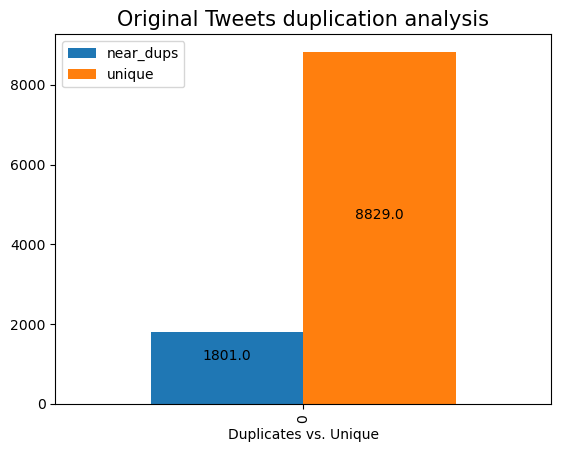

In [43]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Original Tweets duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [44]:
df_dups_text.unpersist()

distCol,id_A,id_B,text_A,text_B
0.0,5032,9643,{Join @vanessa_va...,{Join @vanessa_va...
0.0,6700,9643,{Join @vanessa_va...,{Join @vanessa_va...
0.09999999999999998,4293,4594,{The difference b...,{The difference b...
0.3076923076923077,8841,10250,{The difference b...,{The difference b...
0.6363636363636364,906,5351,{@fcurrocary This...,{@Cernovich 100%…...
0.6923076923076923,7083,7213,{Do Branch Bernid...,{@WhiteHouse @POT...
0.0,7986,8226,{@apatwx @marklev...,{@Stlcardcollect4...
0.631578947368421,7630,8475,{Grant vs Verdugo...,{Grants vs Valenc...
0.6,2523,2924,{@adinross Pay fo...,{@charlescwcooke ...
0.0,3648,7414,{Join @vanessa_va...,{Join @vanessa_va...


In [45]:
df_dups_30_id = df_dups_30.select(col('id_A').alias('id_30_A'), col('id_B').alias('id_30_B'))
df_dups_50_id = df_dups_50.select(col('id_A').alias('id_50_A'), col('id_B').alias('id_50_B'))
df_dups_70_id = df_dups_70.select(col('text_A'), col('text_B'),\
                                  col('id_A').alias('id_70_A'), col('id_B').alias('id_70_B'))

print(df_dups_30_id.count())
print(df_dups_50_id.count())
print(df_dups_70_id.count())

15441


18246


31339


In [46]:
dups_combined = df_dups_70_id.join(df_dups_50_id, on=((df_dups_70_id.id_70_A == df_dups_50_id.id_50_A) & (df_dups_70_id.id_70_B == df_dups_50_id.id_50_B)), how="left_outer")\
.join(df_dups_30_id, on=((df_dups_70_id.id_70_A == df_dups_30_id.id_30_A) & (df_dups_70_id.id_70_B == df_dups_30_id.id_30_B)), how="left_outer")

dups_combined.limit(5)

text_A,text_B,id_70_A,id_70_B,id_50_A,id_50_B,id_30_A,id_30_B
{The difference b...,{The difference b...,4293,4594,4293,4594,4293,4594
{#篮球 #百家乐https:/...,{@marbethflies @p...,408,3430,null,null,null,null
{@sweetcher62 @Ra...,{Personal Loan Fo...,2345,4219,null,null,null,null
{The difference b...,{The difference b...,8841,10250,8841,10250,null,null
{@sweetcher62 @Ra...,{@pulte Would lov...,2345,5339,null,null,null,null


In [47]:
dups_combined = dups_combined.\
withColumn("threshold_30",\
           when(col("id_30_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
withColumn("threshold_50",\
           when(col("id_50_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
withColumn("threshold_70",\
           when(col("id_70_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
drop('id_30_A', 'id_30_B', 'id_50_A', 'id_50_B', 'id_70_A', 'id_70_B')

dups_combined.limit(5)

text_A,text_B,threshold_30,threshold_50,threshold_70
{@RobinhoodApp Fr...,{@nimrodzNFT I fo...,Duplicate,Duplicate,Duplicate
{@CryptoEmdarks F...,{@cryptojack guys...,Duplicate,Duplicate,Duplicate
{@cryptojack Guys...,{@MarketChartsApp...,Duplicate,Duplicate,Duplicate
{@TheMoonCarl @Yo...,{@NftPhhuoo Frien...,Duplicate,Duplicate,Duplicate
{@cryptojack Guys...,{@hotsmeta Friend...,Duplicate,Duplicate,Duplicate


In [48]:
dups_combined_sample = \
dups_combined.filter(("threshold_30 == 'Duplicate'")).sample(False, 0.1, 12345).limit(10).\
union\
(dups_combined.filter(("threshold_30 == 'Non-Dup' and threshold_50 == 'Duplicate'")).sample(False, 0.1, 12345).limit(10)).\
union\
(dups_combined.filter(("threshold_50 == 'Non-Dup'")).sample(False, 0.1, 12345).limit(10)).\
orderBy('threshold_30', 'threshold_50', 'threshold_70')

In [49]:
pd.set_option('display.max_rows', 30)
dups_combined_sample.limit(1000).toPandas()

,text_A,text_B,threshold_30,threshold_50,threshold_70
0,"(Join @vanessa_vash, @Malala and human rights champions’ urgent call on world leaders to expand children’s right to free education #AllKidsInSchool #TransformingEducation. Add your voice here: https://t.co/Rk3RGZ41qm,)","(Join @vanessa_vash, @Malala and human rights champions’ urgent call on world leaders to expand children’s right to free education #AllKidsInSchool #TransformingEducation. Add your voice here: https://t.co/AP5cPR4qOU,)",Duplicate,Duplicate,Duplicate
1,"(Join @vanessa_vash, @Malala and human rights champions’ urgent call on world leaders to expand children’s right to free education #AllKidsInSchool #TransformingEducation. Add your voice here: https://t.co/BnsYLAxBf1,)","(Join @vanessa_vash, @Malala and human rights champions’ urgent call on world leaders to expand children’s right to free education #AllKidsInSchool #TransformingEducation. Add your voice here: https://t.co/ItTO0YxZ18,)",Duplicate,Duplicate,Duplicate
2,"(@MasteryOfLife_ ^^^^ this is College debt forgiveness!!!,)","(@here4fredom @Conor_Maloney_ @JeremyUden @davidhogg111 Then why is there a college debt problem?,)",Duplicate,Duplicate,Duplicate
3,"(Yes, you can still apply for School Choice and go to Adams Elementary (or maybe Grant?),)","(Yes, you can still apply for School Choice and go to Hancock Elementary (or maybe Grant?),)",Duplicate,Duplicate,Duplicate
4,"(Join @vanessa_vash, @Malala and human rights champions’ urgent call on world leaders to expand children’s right to free education #AllKidsInSchool #TransformingEducation. Add your voice here: https://t.co/V6FVEJBMSs,)","(Join @vanessa_vash, @Malala and human rights champions’ urgent call on world leaders to expand children’s right to free education #AllKidsInSchool #TransformingEducation. Add your voice here: https://t.co/nWb1shSpA2,)",Duplicate,Duplicate,Duplicate
5,"(Yes, you can still apply for School Choice and go to Alcott Elementary (or maybe Grant?),)","(Yes, you can still apply for School Choice and go to Hancock Elementary (or maybe Grant?),)",Duplicate,Duplicate,Duplicate
6,"(Join @vanessa_vash, @Malala and human rights champions’ urgent call on world leaders to expand children’s right to free education #AllKidsInSchool #TransformingEducation. Add your voice here: https://t.co/iGcSafI6o5,)","(Join @vanessa_vash, @Malala and human rights champions’ urgent call on world leaders to expand children’s right to free education #AllKidsInSchool #TransformingEducation. Add your voice here: https://t.co/Pocdk7rKtR,)",Duplicate,Duplicate,Duplicate
7,"(Join @vanessa_vash, @Malala and human rights champions’ urgent call on world leaders to expand children’s right to free education #AllKidsInSchool #TransformingEducation. Add your voice here: https://t.co/Rk3RGZ41qm,)","(Join @vanessa_vash, @Malala and human rights champions’ urgent call on world leaders to expand children’s right to free education #AllKidsInSchool #TransformingEducation. Add your voice here: https://t.co/nWb1shSpA2,)",Duplicate,Duplicate,Duplicate
8,"(@TheMoonCarl Friends, I found a part-time job suitable for college students, I can even pay for my tuition! AEXd's campus partnership program, this program can pay $2200 per month for output work, if you are interested, please DM TG @AexJack001 @Aexpartnership. thanks,)","(@BNBCHAIN @KenziBNB hello guys, I found a part-time job suitable for college students,\n I can even pay for my tuition! AEXd's campus partnership program,\n this program can pay $2200 per month for output work, if you are interested,\n please DM TG @AEXJack @Aexpartnership. thanks,)",Duplicate,Duplicate,Duplicate
9,"(@SweetApesNFT Friends, I found a part-time job suitable for college students, I can even pay for my tuition! AEXd's campus partnership program, this program can pay $2200 per month for output work, if you are interested, please DM TG @AEXJack @Aexpartnership. thanks,)","(@CaptainMrMars Hey mate I found a part-time job suitable for college s

In [55]:
df_text_raw = df.filter((col('retweeted') != 'RT') & (col('is_quote_status') == 'false'))\
            .select(col('tweet_text'),(col('user_type')))

In [56]:
df_text_raw.groupBy('user_type').count()

user_type,count
university,1522
school,568
other,414460
non-profit,1292
influencer,4234
government,1502


In [66]:
df.filter(col('user_type') == 'university')

coordinates,created_at,favorite_count,favorited,filter_level,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,is_quote_status,lang,place,quote_count,quoted_status,quoted_status_id,quoted_text,reply_count,retweet_count,retweeted,retweeted_from,retweeted_status,source,text,timestamp_ms,truncated,tweet_text,user,entities,extended_entities,extended_tweet,geo,place.country,place.full_name,place.name,place.place_type,user.id,user.name,user.screen_name,user.location,user.created_at,user.description,user.followers_count,user.friends_count,user.listed_count,user.favourites_count,user.statuses_count,user.url,user.verified,retweets_count,user_type,user_type_nv,hashtags
null,Thu Aug 25 01:42:...,0,false,low,1562616306192359424,null,null,null,false,en,null,0,null,null,null,0,0,,null,null,"<a href=""http://t...",Donald Trump scam...,1661391734060,true,Donald Trump scam...,"{false, Sun Aug 1...","{[], null, [], [{...",null,"{[0, 260], {[], n...",null,null,null,null,null,15801906,Tristan Snell,TristanSnell,"New York, NY",Sun Aug 10 22:13:...,"Lawyer, founder h...",265538,26581,1004,5671,9193,http://mainstreet...,true,null,university,university,[]
null,Tue May 03 18:37:...,0,false,low,1521559548577804289,null,null,null,false,en,null,0,null,null,null,0,0,,null,null,"<a href=""https://...",Funded fellowship...,1651603040247,false,Funded fellowship...,"{false, Wed Feb 0...","{[], null, [], [{...",null,null,null,null,null,null,null,20038291,Sridhar Venkatapu...,sridhartweet,"Roots in India, U...",Wed Feb 04 08:49:...,Helping to achiev...,5058,4017,122,29170,19661,https://linktr.ee...,true,null,university,university,[]
null,Wed Apr 27 20:00:...,0,false,low,1519406241516240899,null,null,null,false,en,null,0,null,null,null,0,0,,null,null,"<a href=""https://...","$100,000 in Grant...",1651089651837,true,"$100,000 in Grant...","{false, Thu Feb 2...","{[], null, [], [{...",null,"{[0, 164], {[], [...",null,null,null,null,null,117274820,Texas A&M Univers...,TAMUSanAntonio,"San Antonio, TX",Thu Feb 25 02:50:...,Official Twitter ...,8575,814,137,5155,9537,http://becomeajag...,true,null,university,university,[]
null,Mon Aug 29 15:19:...,0,false,low,1564271573644746753,glastris,1564271568179662848,17755154,false,en,null,0,null,null,null,0,0,,monthly ranks col...,null,"<a href=""https://...","Second, unlike U....",1661786380574,true,"Second, unlike U....","{false, Sun Nov 3...","{[], null, [], [{...",null,"{[0, 272], {[], n...",null,null,null,null,null,17755154,Paul Glastris,glastris,"Washington, DC",Sun Nov 30 14:45:...,EIC of @monthly f...,4104,1104,129,1929,25269,http://washington...,true,null,university,university,[]
null,Wed Apr 27 19:50:...,0,false,low,1519403649184591872,null,null,null,false,en,null,0,null,null,null,0,0,RT,latimes,"{null, Wed Apr 27...","<a href=""https://...",RT @latimes: Star...,1651089033777,false,Starting in the f...,"{false, Fri Sep 2...","{[], null, [], []...",null,null,null,null,null,null,null,1912521805,Annenberg Inclusi...,Inclusionists,"Los Angeles, CA",Fri Sep 27 22:44:...,Dr Stacy Smith & ...,14023,750,301,12397,28403,http://annenberg....,true,14,university,university,[]
null,Wed Nov 16 00:00:...,0,false,low,1592668789623111680,null,null,null,false,en,null,0,null,null,null,0,0,,null,null,"<a href=""https://...",BigFuture Live Ne...,1668556804458,true,BigFuture Live Ne...,"{false, Wed Apr 0...","{[{[73, 81], NewY...",null,"{[0, 222], {[{[73...",null,null,null,null,null,29716569,College Board,CollegeBoard,"New York, NY",Wed Apr 08 13:41:...,A non-profit clea...,207966,1145,1420,9805,36176,http://www.colleg...,true,null,university,university,[NewYork]
null,Wed Aug 24 19:15:...,0,false,low,1562518861852815370,null,null,null,false,en,null,0,null,null,null,0,0,,null,null,"<a href=""https://...",College of Nursin...,1661368501519,false,College of Nursin...,"{false, Sat May 0...","{[], [{null, null...","{[{null, null, pi...",null,null,null,null,null,null,5794972,Seton Hall,SetonHall,"South Orange, NJ",Sat May 05 

In [68]:
df.filter(col('user_type') == 'school')

coordinates,created_at,favorite_count,favorited,filter_level,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,is_quote_status,lang,place,quote_count,quoted_status,quoted_status_id,quoted_text,reply_count,retweet_count,retweeted,retweeted_from,retweeted_status,source,text,timestamp_ms,truncated,tweet_text,user,entities,extended_entities,extended_tweet,geo,place.country,place.full_name,place.name,place.place_type,user.id,user.name,user.screen_name,user.location,user.created_at,user.description,user.followers_count,user.friends_count,user.listed_count,user.favourites_count,user.statuses_count,user.url,user.verified,retweets_count,user_type,user_type_nv,hashtags
null,Mon May 09 14:11:...,0,false,low,1523666995564412931,null,null,null,false,en,null,0,null,null,null,0,0,,schoolnurses fo… ...,null,"<a href=""https://...",It’s National Nur...,1652105494763,true,It’s National Nur...,"{false, Mon May 1...","{[], null, [], [{...",null,"{[0, 215], {[{[19...",null,null,null,null,null,144931880,Alexandria City P...,ACPSk12,"Alexandria, Virgi...",Mon May 17 17:56:...,Official tweets f...,19638,387,266,4106,34592,https://www.acps....,true,null,school,school,[]
null,Tue Nov 22 16:11:...,0,false,low,1595087525483274241,null,null,null,false,en,null,0,null,null,null,0,0,,null,null,"<a href=""https://...",Do you know any l...,1669133476025,true,Do you know any l...,"{false, Mon Mar 0...","{[], null, [], [{...",null,"{[0, 283], {[{[10...",null,null,null,null,null,23403378,Rare Book School,rarebookschool,"Charlottesville, VA",Mon Mar 09 04:49:...,RBS is a non-prof...,10923,836,242,1274,1483,http://www.rarebo...,true,null,school,school,[]
null,Wed Nov 16 01:11:...,0,false,low,1592686655789727746,null,null,null,false,en,null,0,null,null,null,0,0,RT,CUNY,"{null, Fri Nov 11...","<a href=""http://t...",RT @CUNY: .@CUNYS...,1668561064084,false,.@CUNYSPS has one...,"{false, Sat May 1...","{[], null, [], []...",null,null,null,null,null,null,null,40480271,Jorge Silva-Puras,silvapuras,NYC,Sat May 16 15:17:...,"Dean at @CUNYSPS,...",9440,3977,209,14339,6471,https://www.linke...,true,3,school,school,[]
null,Fri Aug 12 22:02:...,0,false,low,1558212237893976066,null,null,null,false,en,null,0,null,null,null,0,0,,null,null,"<a href=""https://...",Applications are ...,1660341722354,true,Applications are ...,"{false, Sun Aug 3...","{[], null, [], [{...",null,"{[0, 280], {[{[12...",null,null,null,null,null,70250595,"NASN, Inc.",schoolnurses,"Silver Spring, Ma...",Sun Aug 30 23:56:...,The mission of th...,10192,1104,209,4555,11076,http://www.nasn.org,true,null,school,school,[]
null,Thu Aug 25 17:12:...,0,false,low,1562850336989057026,null,null,null,false,en,null,0,null,null,null,0,0,RT,POTUS,"{null, Thu Aug 25...","<a href=""https://...",RT @POTUS: The bu...,1661447531350,false,The burden of stu...,"{false, Fri Apr 1...","{[], null, [], []...",null,null,null,null,null,null,null,32453116,PA House Democrats,PaHouseDems,Pennsylvania,Fri Apr 17 15:46:...,"Better Jobs, Bett...",39838,4784,587,928,57806,http://PaHouse.com,true,4066,school,school,[]
null,Thu Aug 25 21:10:...,0,false,low,1562910350764556289,null,null,null,false,en,null,0,null,null,null,0,0,RT,GovRonDeSantis,"{null, Thu Aug 25...","<a href=""https://...",RT @GovRonDeSanti...,1661461839749,false,It’s unfair to fo...,"{false, Tue Aug 0...","{[], null, [], []...",null,null,null,null,null,null,null,8006742,Ryan Petty,rpetty,"Florida, USA",Tue Aug 07 00:37:...,Official account ...,20796,1307,157,68603,5659,https://ryanpetty...,true,8516,school,school,[]
null,Thu Apr 14 18:03:...,0,false,low,1514665580917313547,null,null,null,false,en,null,0,null,null,null,0,0,,the Food Entrepr...,null,"<a href=""https://...",Now @ the Food En...,1649959390273,true,Now @ the Food En...,"{false, Thu May 2...","{[], null, [], [{...",null,"{[0, 288], {[], [...",null,null,null,null,null,305777588,Tufts Nutrition,TuftsNutrition,"Boston, MA",Thu May 26 19:42:...,Gerald J. and Dor...,12137,1157,270,6501,11097,http://nutr

In [69]:
df.filter(col('user_type') == 'non-profit')

coordinates,created_at,favorite_count,favorited,filter_level,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,is_quote_status,lang,place,quote_count,quoted_status,quoted_status_id,quoted_text,reply_count,retweet_count,retweeted,retweeted_from,retweeted_status,source,text,timestamp_ms,truncated,tweet_text,user,entities,extended_entities,extended_tweet,geo,place.country,place.full_name,place.name,place.place_type,user.id,user.name,user.screen_name,user.location,user.created_at,user.description,user.followers_count,user.friends_count,user.listed_count,user.favourites_count,user.statuses_count,user.url,user.verified,retweets_count,user_type,user_type_nv,hashtags
null,Thu Aug 25 01:42:...,0,false,low,1562616497737850880,pstumler,1562615651595800577,18531689,false,en,null,0,null,null,null,0,0,,null,null,"<a href=""http://t...",@pstumler Poor pe...,1661391779728,true,@pstumler Poor pe...,"{false, Wed Feb 2...","{[], null, [], [{...",null,"{[10, 215], {[], ...",null,null,null,null,null,21920725,Matt Jones,KySportsRadio,"Lexington, Kentucky",Wed Feb 25 21:21:...,Host of KSR with ...,256786,2707,1919,7618,102727,http://kentuckysp...,true,null,non-profit,non-profit,[]
null,Tue Aug 23 16:40:...,0,false,low,1562117600808763395,null,null,null,false,en,null,0,null,null,null,0,0,RT,JohnArnoldFndtn,"{null, Tue Aug 23...","<a href=""http://t...",RT @JohnArnoldFnd...,1661272833431,false,Smart higher ed r...,"{false, Wed Jun 1...","{[], null, [], []...",null,null,null,null,null,null,null,3331471966,Ben Ritz 🇺🇦 SAV...,BudgetBen,"Arlington, VA",Wed Jun 17 15:28:...,Director of @PPI’...,5188,592,110,74627,32172,https://www.progr...,true,4,non-profit,non-profit,[]
null,Thu Apr 28 00:43:...,0,false,low,1519477356398002176,null,null,null,false,en,null,0,null,null,null,0,0,,null,null,"<a href=""https://...",If tuition-free u...,1651106606946,true,If tuition-free u...,"{false, Thu May 3...","{[], null, [], [{...",null,"{[0, 280], {[], n...",null,null,null,null,null,6473022,Christian Christe...,ChrChristensen,null,Thu May 31 14:18:...,American. Prof. o...,30491,2728,640,4433,81886,null,true,null,non-profit,non-profit,[]
null,Sat Apr 23 17:00:...,0,false,low,1517911222045351936,null,null,null,false,en,null,0,null,null,null,0,0,,null,null,"<a href=""http://w...","""It stinks that y...",1650733211419,true,"""It stinks that y...","{false, Fri Mar 2...","{[], null, [], [{...",null,"{[0, 204], {[], n...",null,null,null,null,null,14192680,NOLA.com,NOLAnews,"New Orleans, LA",Fri Mar 21 18:03:...,Latest news and u...,286562,1568,3156,1471,351701,http://www.nola.com,true,null,non-profit,non-profit,[]
null,Wed Aug 24 20:18:...,0,false,low,1562534810911797248,null,null,null,false,en,null,0,null,null,null,0,0,RT,meyerweb,"{null, Wed Aug 24...","<a href=""http://t...",RT @meyerweb: For...,1661372304071,false,For all your coll...,"{false, Fri May 1...","{[], [{null, A dr...","{[{null, A drawin...",null,null,null,null,null,null,5959342,Charles Arthur,charlesarthur,“We are where we ...,Fri May 11 12:07:...,"Journalist, speak...",74397,1416,3948,11526,258722,https://www.amazo...,true,260,non-profit,non-profit,[]
null,Wed Aug 24 20:18:...,0,false,low,1562534827051560961,jasonfurman,1562503985529233410,279036722,false,en,null,0,null,null,null,0,0,,null,null,"<a href=""http://t...",@jasonfurman Also...,1661372307919,true,@jasonfurman Also...,"{false, Sun Mar 1...","{[], null, [], [{...",null,"{[13, 289], {[], ...",null,null,null,null,null,24518690,Seth Frantzman,sfrantzman,null,Sun Mar 15 12:45:...,Middle East secur...,55284,12401,1055,65189,116484,http://sethfrantz...,true,null,non-profit,non-profit,[]
null,Tue Apr 19 16:03:...,0,false,low,1516447399073439747,The74,1516447395588059141,3301029022,false,en,null,0,null,null,null,0,0,,null,null,"<a href=""https://...","Samantha Farrow, ...",1650384208826,true,"Samantha Farrow, ...","{false, Wed May 2...","{[], null, [], [{...",null,"{[0, 198], {[], [...",null,null,null,null,null,3301029022,The 74,The74,"New Y

In [70]:
df.filter(col('user_type') == 'news')

coordinates,created_at,favorite_count,favorited,filter_level,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,is_quote_status,lang,place,quote_count,quoted_status,quoted_status_id,quoted_text,reply_count,retweet_count,retweeted,retweeted_from,retweeted_status,source,text,timestamp_ms,truncated,tweet_text,user,entities,extended_entities,extended_tweet,geo,place.country,place.full_name,place.name,place.place_type,user.id,user.name,user.screen_name,user.location,user.created_at,user.description,user.followers_count,user.friends_count,user.listed_count,user.favourites_count,user.statuses_count,user.url,user.verified,retweets_count,user_type,user_type_nv,hashtags


In [67]:
df.filter(col('user.screen_name') == 'SetonHall').select(col('user.description')).show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------+
|description                                                                                                                    |
+-------------------------------------------------------------------------------------------------------------------------------+
|As one of the nation's leading Catholic universities, Seton Hall has been showing the world what great minds can do since 1856.|
|As one of the nation's leading Catholic universities, Seton Hall has been showing the world what great minds can do since 1856.|
|As one of the nation's leading Catholic universities, Seton Hall has been showing the world what great minds can do since 1856.|
|As one of the nation's leading Catholic universities, Seton Hall has been showing the world what great minds can do since 1856.|
|As one of the nation's leading Catholic universities, Seton Hall has been showing the wor

In [62]:
df_text_raw_uni = df.filter((col('retweeted') != 'RT') & (col('is_quote_status') == 'false') &\
                        (col('user_type') == 'university'))\
            .select(col('tweet_text').alias('text')

In [64]:
df_text_raw_uni.show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                                                                                                                                                                                         |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Donald Trump scammed 9,000 students out of $42 million in the illegal unlicensed “Trump